# Fully Convolutional Neural Networks (FCNNs) - Denoising Example



In [2]:
# Import additional libraries if you need
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Denoising FCNN

Develop a FCNN model that receives as input 20 1-dimensional noisy measurements of the same signal and outputs the denoised signal.

- Data download link: https://drive.google.com/file/d/1O811Dsz8e_R2zfXVoeXMG2ZeayBUdoVn/view?usp=sharing


### 2.1 Load data  and split into train, validation, test

In [3]:
# Loading the data
data = np.load("data/denoising-1d/noisy_transients.npy")
target = np.load("data/denoising-1d/reference.npy")

# Shuffle the samples
indexes = np.arange(data.shape[0], dtype=int)
np.random.shuffle(indexes)
data = data[indexes]
target = target[indexes]

# Splitting the data into train/val/test
X_train = data[:int(data.shape[0] * 0.8)]
Y_train = target[:int(data.shape[0] * 0.8)]

X_val = data[int(data.shape[0] * 0.8):int(data.shape[0] * 0.9)]
Y_val = target[int(data.shape[0] * 0.8):int(data.shape[0] * 0.9)]

X_test = data[int(data.shape[0] * 0.9):]
Y_test = target[int(data.shape[0] * 0.9):]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(216, 256, 20)
(27, 256, 20)
(27, 256, 20)


### 2.2. Explore your data

In [4]:
print(f'Min: {X_train.min():.3f}')
print(f'Max: {X_train.max():.3f}')
print(f'Mean: {X_train.mean():.3f}')
print(f'Standard deviation: {X_train.std():.3f}')

Min: -2.917
Max: 3.746
Mean: 0.204
Standard deviation: 0.728


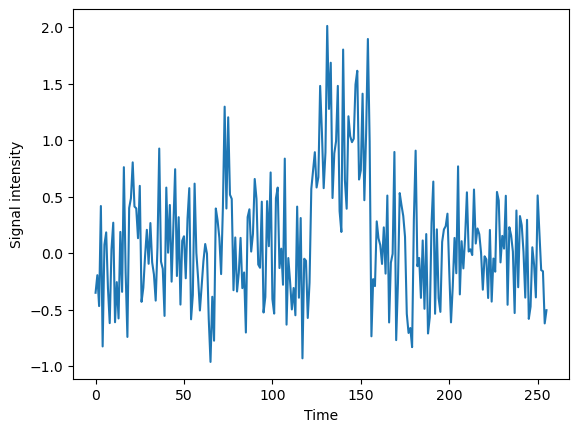

In [5]:
plt.plot(X_train[0, :, 0])
plt.xlabel('Time')
plt.ylabel('Signal intensity')
plt.show()

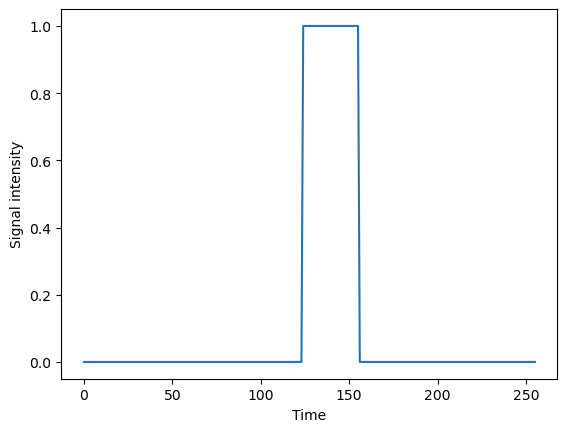

In [6]:
plt.plot(Y_train[0, :])
plt.xlabel('Time')
plt.ylabel('Signal intensity')
plt.show()

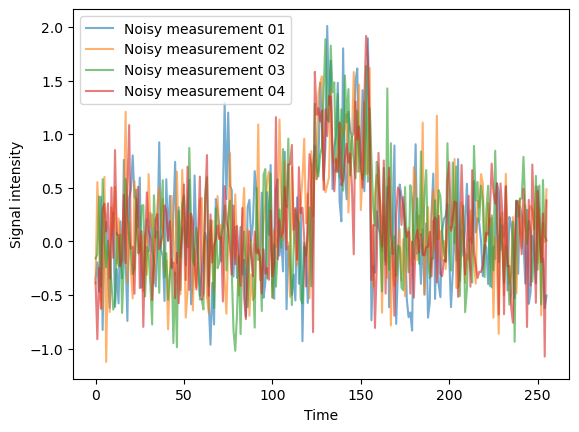

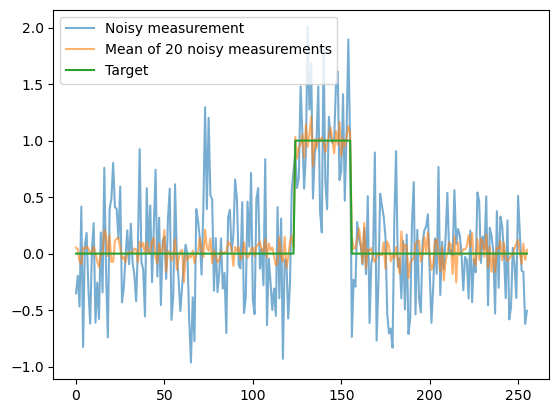

In [7]:
plt.figure()
plt.plot(X_train[0, :, 0], label="Noisy measurement 01", alpha=0.6)
plt.plot(X_train[0, :, 1], label="Noisy measurement 02", alpha=0.6)
plt.plot(X_train[0, :, 2], label="Noisy measurement 03", alpha=0.6)
plt.plot(X_train[0, :, 3], label="Noisy measurement 04", alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Signal intensity')
plt.legend()
plt.show()

plt.figure()
plt.plot(X_train[0, :, 0], label="Noisy measurement", alpha=0.6)
plt.plot(X_train[0, :, :].mean(axis=-1), label="Mean of 20 noisy measurements", alpha=0.6)
plt.plot(Y_train[0, :], label="Target")
plt.legend()
plt.show()

### 2.3. Data normalization

In [8]:
mean_train, std_train = X_train.mean(), X_train.std()

Xtrain_norm = (X_train - mean_train) / std_train 
Ytrain_norm = (Y_train - mean_train) / std_train

Xval_norm = (X_val - mean_train) / std_train
Yval_norm = (Y_val - mean_train) / std_train

Xtest_norm = (X_test - mean_train) / std_train
Ytest_norm = (Y_test - mean_train) / std_train

In [9]:
print(f'Min: {Xtrain_norm.min():.3f}')
print(f'Max: {Xtrain_norm.max():.3f}')
print(f'Mean: {Xtrain_norm.mean():.3f}')
print(f'Standard deviation: {Xtrain_norm.std():.3f}')

Min: -4.285
Max: 4.863
Mean: -0.000
Standard deviation: 1.000


### 2.4. Define your  model

In [10]:
class Fcnn_1d(nn.Module):
    def __init__(self, in_channels=20):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=60, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=60, out_channels=60, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=60, out_channels=60, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=60, out_channels=60, kernel_size=3, padding=1)
        self.out = nn.Conv1d(in_channels=60, out_channels=1, kernel_size=1, padding=0) 
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.out(x)
        
        return x
    
fcnn = Fcnn_1d()
num_params = sum(p.numel() for p in fcnn.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params}')
fcnn


Number of parameters: 36301


Fcnn_1d(
  (conv1): Conv1d(20, 60, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(60, 60, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(60, 60, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(60, 60, kernel_size=(3,), stride=(1,), padding=(1,))
  (out): Conv1d(60, 1, kernel_size=(1,), stride=(1,))
)

In [11]:
class UnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding='same')
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding='same')
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        return x


class Unet_1d(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoding path
        self.block1 = UnetBlock(20, 60, 3)
        self.block2 = UnetBlock(60, 120, 3)
        self.block3 = UnetBlock(120, 240, 3)
        
        # Decoder Path
        self.block4 = UnetBlock(360, 120, 3)
        self.block5 = UnetBlock(180, 60, 3)
        self.out = nn.Conv1d(60, 1, 1)
    
    def forward(self, x):
        # Nx20x256
        out1 = self.block1(x)  # Nx60x256
        x = F.max_pool1d(out1, kernel_size=2, stride=2) # Nx60x128
        out2 = self.block2(x) # Nx120x128
        x = F.max_pool1d(out2, kernel_size=2, stride=2) # Nx120x64
        x = self.block3(x) # Nx240x64

        x = F.upsample(x, scale_factor=2) # Nx240x128
        x = torch.concat([x, out2], dim=1) # Nx360x128
        x = self.block4(x)  # Nx120x128
        x = F.upsample(x, scale_factor=2)  # Nx120x256
        x = torch.concat([x, out1], dim=1) # Nx180x256
        x = self.block5(x) # Nx60x256
        
        out = self.out(x) # Nx1x256
        return out
    
unet = Unet_1d()
num_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params}')
unet

Number of parameters: 555661


Unet_1d(
  (block1): UnetBlock(
    (conv1): Conv1d(20, 60, kernel_size=(3,), stride=(1,), padding=same)
    (conv2): Conv1d(60, 60, kernel_size=(3,), stride=(1,), padding=same)
  )
  (block2): UnetBlock(
    (conv1): Conv1d(60, 120, kernel_size=(3,), stride=(1,), padding=same)
    (conv2): Conv1d(120, 120, kernel_size=(3,), stride=(1,), padding=same)
  )
  (block3): UnetBlock(
    (conv1): Conv1d(120, 240, kernel_size=(3,), stride=(1,), padding=same)
    (conv2): Conv1d(240, 240, kernel_size=(3,), stride=(1,), padding=same)
  )
  (block4): UnetBlock(
    (conv1): Conv1d(360, 120, kernel_size=(3,), stride=(1,), padding=same)
    (conv2): Conv1d(120, 120, kernel_size=(3,), stride=(1,), padding=same)
  )
  (block5): UnetBlock(
    (conv1): Conv1d(180, 60, kernel_size=(3,), stride=(1,), padding=same)
    (conv2): Conv1d(60, 60, kernel_size=(3,), stride=(1,), padding=same)
  )
  (out): Conv1d(60, 1, kernel_size=(1,), stride=(1,))
)

### 2.5 Initalize data loaders

In [12]:
def get_data_loader(x, y, bs):
    # Permute np.array from NLC TO NCL
    x = torch.permute(torch.Tensor(x), dims=(0, 2, 1))
    y = torch.Tensor(y)
    return DataLoader(
        TensorDataset(x, y),
        batch_size=bs
    )

train_loader = get_data_loader(Xtrain_norm, Ytrain_norm, 8)
val_loader = get_data_loader(Xval_norm, Yval_norm, 8)
test_loader = get_data_loader(Xtest_norm, Ytest_norm, 27)

for x, y in train_loader:
    break

print(x.shape)
print(y.shape)


torch.Size([8, 20, 256])
torch.Size([8, 256])


### 2.6. Define early stopping functions

In [13]:
class EarlyStopper():
    def __init__(self, patience=3):
        self.best_val = np.inf
        self.current_val = np.inf
        self.patience = patience
        self.steps_since_last_best = 0
        
    def __call__(self, val) -> bool:
        self.current_val = val
        self._update_best()
        if self.steps_since_last_best == self.patience:
            return True
        else:
            return False
        
    def _update_best(self):
        if self.current_val < self.best_val:
            print(f"New best mse: {self.current_val:.4f}")
            self.best_val = self.current_val
            self.steps_since_last_best = 0
        else:
            self.steps_since_last_best += 1
        
        
def train(model, optim, scheduler, criterion, train_loader) -> None:
    device = next(iter(fcnn.parameters())).device
    model.train()
    total_loss = 0
    for x,y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred.squeeze(), y)
        loss.backward()
        optim.step()
        optim.zero_grad()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    scheduler.step(avg_loss)

@torch.no_grad()
def validate(model, val_loader, criterion) -> float: 
    model.eval()
    device = next(iter(fcnn.parameters())).device
    total_loss = 0
    for x,y in val_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred.squeeze(), y) # Remove channel dim from y_pred
        total_loss+=loss.item()
    return total_loss / len(val_loader)


### 2.6 Train FCNN

In [14]:
best_model_path = "weights/best_model_fcnn.pt"
epochs = 20
model = Fcnn_1d()
optim = torch.optim.Adam(params=model.parameters())
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim,
    "min",
    factor=0.1,
    patience=2,
    verbose=True
)
criterion = nn.MSELoss(reduction="mean")
early_stopper = EarlyStopper(patience=3)
model.to(device)

train_losses_fcnn = []
val_losses_fcnn = []

for epoch in range(epochs):
    ## TRAIN LOOP ##
    train_loss = 0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred.squeeze(), y) # Remove channel dim from y_pred
        loss.backward()
        
        optim.step()
        optim.zero_grad()
        train_loss += loss.item()
        
    train_loss = train_loss / len(train_loader)
    train_losses_fcnn.append(train_loss)
    print(f'\n{epoch + 1},  train loss: {train_loss:.6f}')

    ## VAL LOOP ##
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred.squeeze(), y) 
            val_loss += loss.item()
            
        val_loss / len(val_loader)
        val_losses_fcnn.append(val_loss)
        print(f'val loss: {val_loss:.6f}')

        if early_stopper(val_loss):
            break
        if early_stopper.steps_since_last_best == 0:
            torch.save(model, best_model_path)




1,  train loss: 0.202402
val loss: 0.121640
New best mse: 0.1216

2,  train loss: 0.016323
val loss: 0.040845
New best mse: 0.0408

3,  train loss: 0.009066
val loss: 0.032258
New best mse: 0.0323

4,  train loss: 0.008084
val loss: 0.031032
New best mse: 0.0310

5,  train loss: 0.007678
val loss: 0.030760
New best mse: 0.0308

6,  train loss: 0.007002
val loss: 0.026384
New best mse: 0.0264

7,  train loss: 0.006171
val loss: 0.022881
New best mse: 0.0229

8,  train loss: 0.005411
val loss: 0.020836
New best mse: 0.0208

9,  train loss: 0.004808
val loss: 0.017665
New best mse: 0.0177

10,  train loss: 0.004411
val loss: 0.016372
New best mse: 0.0164

11,  train loss: 0.004012
val loss: 0.014976
New best mse: 0.0150

12,  train loss: 0.003697
val loss: 0.013622
New best mse: 0.0136

13,  train loss: 0.003498
val loss: 0.012583
New best mse: 0.0126

14,  train loss: 0.003363
val loss: 0.012119
New best mse: 0.0121

15,  train loss: 0.003201
val loss: 0.011348
New best mse: 0.0113

16,

Text(0, 0.5, 'MSE')

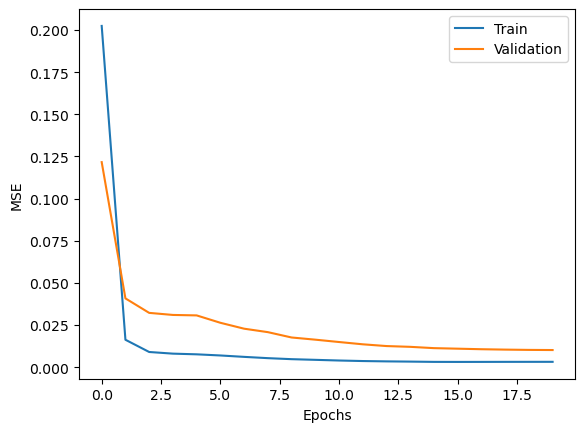

In [15]:
epochs_run_fcnn = np.arange(len(train_losses_fcnn))

plt.plot(epochs_run_fcnn, train_losses_fcnn, label='Train')
plt.plot(epochs_run_fcnn, val_losses_fcnn, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')

### 2.7 Train UNet

In [16]:
best_model_path = "weights/best_model_unet.pt"
epochs = 20
model = Unet_1d()
optim = torch.optim.Adam(params=model.parameters())
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim,
    "min",
    factor=0.1,
    patience=2,
    verbose=True
)
criterion = nn.MSELoss(reduction="mean")
early_stopper = EarlyStopper(patience=3)
model.to(device)

train_losses_unet = []
val_losses_unet = []

for epoch in range(epochs):
    ## TRAIN LOOP ##
    train_loss = 0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred.squeeze(), y) # Remove channel dim from y_pred
        loss.backward()
        optim.step()
        optim.zero_grad()
        train_loss += loss.item()
        
    train_loss = train_loss / len(train_loader)
    train_losses_unet.append(train_loss)
    print(f'\n{epoch + 1},  train loss: {train_loss:.6f}')

    ## VAL LOOP ##
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred.squeeze(), y) 
            val_loss += loss.item()
            
        val_loss / len(val_loader)
        val_losses_unet.append(val_loss)
        print(f'val loss: {val_loss:.6f}')

        if early_stopper(val_loss):
            break
        if early_stopper.steps_since_last_best == 0:
            torch.save(model, best_model_path)

c:\Users\natal\anaconda3\envs\deep_env\lib\site-packages\torch\nn\functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")



1,  train loss: 0.145397
val loss: 0.047500
New best mse: 0.0475

2,  train loss: 0.009226
val loss: 0.034181
New best mse: 0.0342

3,  train loss: 0.007493
val loss: 0.028812
New best mse: 0.0288

4,  train loss: 0.006683
val loss: 0.024045
New best mse: 0.0240

5,  train loss: 0.005551
val loss: 0.017469
New best mse: 0.0175

6,  train loss: 0.004255
val loss: 0.012696
New best mse: 0.0127

7,  train loss: 0.003241
val loss: 0.009242
New best mse: 0.0092

8,  train loss: 0.002560
val loss: 0.008187
New best mse: 0.0082

9,  train loss: 0.002210
val loss: 0.007287
New best mse: 0.0073

10,  train loss: 0.001953
val loss: 0.006695
New best mse: 0.0067

11,  train loss: 0.001778
val loss: 0.006179
New best mse: 0.0062

12,  train loss: 0.001659
val loss: 0.005915
New best mse: 0.0059

13,  train loss: 0.001644
val loss: 0.005579
New best mse: 0.0056

14,  train loss: 0.001625
val loss: 0.005661

15,  train loss: 0.001597
val loss: 0.005850

16,  train loss: 0.001574
val loss: 0.005968


Text(0, 0.5, 'MSE')

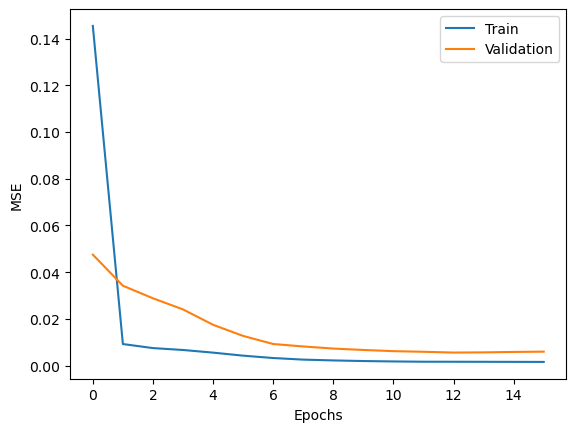

In [17]:
epochs_run_unet = np.arange(len(train_losses_unet))

plt.plot(epochs_run_unet, train_losses_unet, label='Train')
plt.plot(epochs_run_unet, val_losses_unet, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

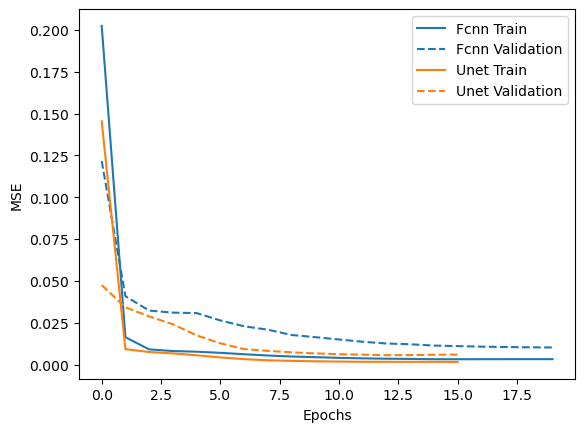

In [18]:
plt.plot(epochs_run_fcnn, train_losses_fcnn, label='Fcnn Train', c='C0', linestyle='-')
plt.plot(epochs_run_fcnn, val_losses_fcnn, label='Fcnn Validation', c='C0', linestyle='--')
plt.plot(epochs_run_unet, train_losses_unet, label='Unet Train', c='C1', linestyle='-')
plt.plot(epochs_run_unet, val_losses_unet, label='Unet Validation', c='C1', linestyle='--')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')

### 2.7. Test your model

In [19]:
# Generate fcnn predictions
fcnn = torch.load("weights/best_model_fcnn.pt")
fcnn.to(device)
fcnn.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        Ypred_fcnn = fcnn(x)

# let's see how well taking an average over the 20 collected signals works...
Ymean = Xtest_norm.mean(axis = -1)

In [20]:
# Remember to "unscale your data".
Ymean_unscaled = Ymean * std_train + mean_train
Ypred_fcnn_unscaled = Ypred_fcnn.squeeze().cpu() * std_train + mean_train

print(f"FCNN MSE: {((Ypred_fcnn_unscaled.squeeze().cpu() - Y_test)**2).mean().item():.6f}")
print(f"Mean signal MSE: {((Ymean_unscaled - Y_test)**2).mean():.6f}")

FCNN MSE: 0.001351
Mean signal MSE: 0.009136


In [21]:
# Now generate unet predictions
unet = torch.load("weights/best_model_unet.pt")
unet.to(device)
unet.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        Ypred_unet = unet(x)

# let's see how well taking an average over the 20 collected signals works...
Ymean = Xtest_norm.mean(axis = -1)

In [22]:
# Remember to "unscale your data".
Ymean_unscaled = Ymean * std_train + mean_train
Ypred_unet_unscaled = Ypred_unet.squeeze().cpu() * std_train + mean_train

print(f"Unet MSE: {((Ypred_unet_unscaled.squeeze().cpu() - Y_test)**2).mean().item():.6f}")
print(f"Mean signal MSE: {((Ymean_unscaled - Y_test)**2).mean():.6f}")

Unet MSE: 0.000746
Mean signal MSE: 0.009136


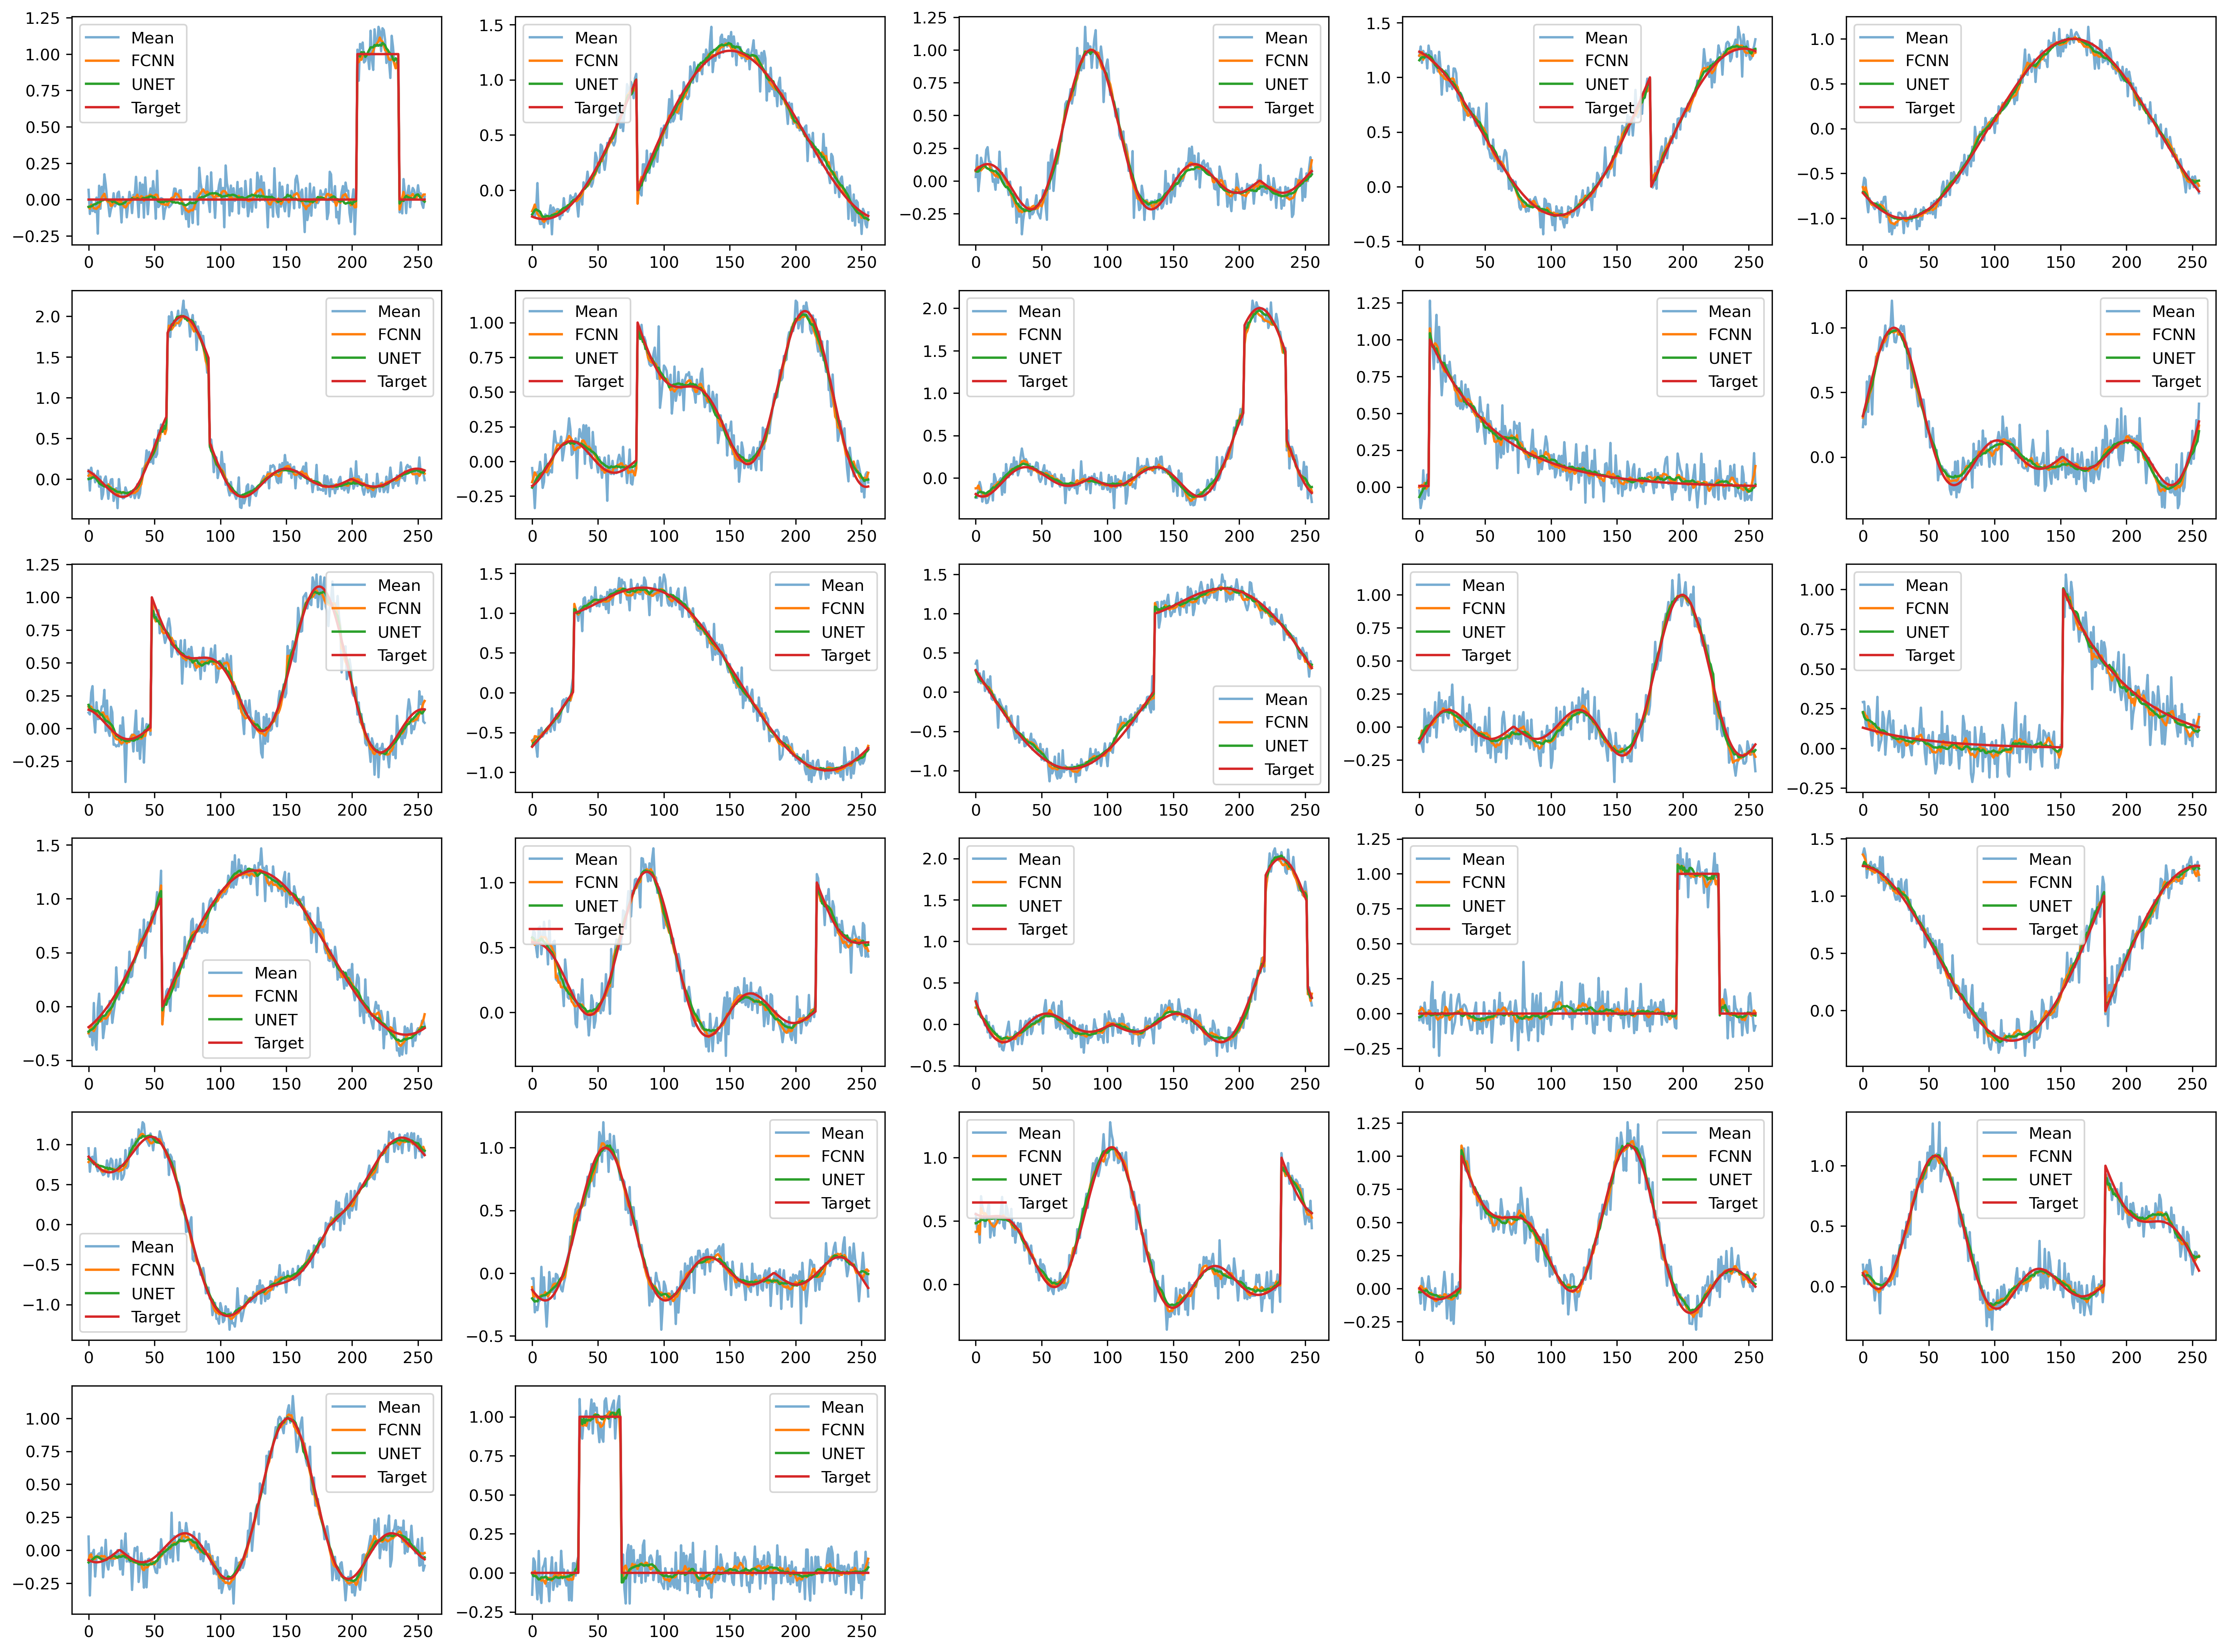

In [23]:
#Showing results
plt.figure(figsize = (24,18), dpi = 300)
for (ii) in range(27):
    plt.subplot(6, 5, ii+1)
    #plt.plot(X_test2[ii,:,0], label = "Noisy")
    plt.plot(Ymean_unscaled[ii], label="Mean", alpha=0.6)
    plt.plot(Ypred_fcnn_unscaled[ii], label="FCNN")
    plt.plot(Ypred_unet_unscaled[ii], label="UNET")
    plt.plot(Y_test[ii], label="Target")
    plt.legend()
plt.show()

### 3.1 Trying other methods

* What if we take a U-net model and remove the skip connections?
* What if we just use a smoothing filter on our mean signal?

#### 3.1.1 'Fake' U-net

In [24]:
class UnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding='same')
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding='same')
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        return x


class Fake_Unet_1d(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoding path
        self.block1 = UnetBlock(20, 60, 3)
        self.block2 = UnetBlock(60, 120, 3)
        self.block3 = UnetBlock(120, 240, 3)
        
        # Decoder Path
        self.block4 = UnetBlock(240, 120, 3)
        self.block5 = UnetBlock(120, 60, 3)
        self.out = nn.Conv1d(60, 1, 1)
    
    def forward(self, x):
        # Nx20x256
        out1 = self.block1(x)  # Nx60x256
        x = F.max_pool1d(out1, kernel_size=2, stride=2) # Nx60x128
        out2 = self.block2(x) # Nx120x128
        x = F.max_pool1d(out2, kernel_size=2, stride=2) # Nx120x64
        x = self.block3(x) # Nx240x64

        # No skip connections this time!
        x = F.upsample(x, scale_factor=2) # Nx240x128
        x = self.block4(x)  # Nx120x128
        x = F.upsample(x, scale_factor=2)  # Nx120x256
        x = self.block5(x) # Nx60x256
        
        out = self.out(x) # Nx1x256
        return out
    
fake_unet = Fake_Unet_1d()
num_params = sum(p.numel() for p in fake_unet.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params}')
fake_unet

Number of parameters: 501661


Fake_Unet_1d(
  (block1): UnetBlock(
    (conv1): Conv1d(20, 60, kernel_size=(3,), stride=(1,), padding=same)
    (conv2): Conv1d(60, 60, kernel_size=(3,), stride=(1,), padding=same)
  )
  (block2): UnetBlock(
    (conv1): Conv1d(60, 120, kernel_size=(3,), stride=(1,), padding=same)
    (conv2): Conv1d(120, 120, kernel_size=(3,), stride=(1,), padding=same)
  )
  (block3): UnetBlock(
    (conv1): Conv1d(120, 240, kernel_size=(3,), stride=(1,), padding=same)
    (conv2): Conv1d(240, 240, kernel_size=(3,), stride=(1,), padding=same)
  )
  (block4): UnetBlock(
    (conv1): Conv1d(240, 120, kernel_size=(3,), stride=(1,), padding=same)
    (conv2): Conv1d(120, 120, kernel_size=(3,), stride=(1,), padding=same)
  )
  (block5): UnetBlock(
    (conv1): Conv1d(120, 60, kernel_size=(3,), stride=(1,), padding=same)
    (conv2): Conv1d(60, 60, kernel_size=(3,), stride=(1,), padding=same)
  )
  (out): Conv1d(60, 1, kernel_size=(1,), stride=(1,))
)

In [25]:
best_model_path = "weights/best_model_fake_unet.pt"
epochs = 20
model = Fake_Unet_1d()
optim = torch.optim.Adam(params=model.parameters())
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim,
    "min",
    factor=0.1,
    patience=2,
    verbose=True
)
criterion = nn.MSELoss(reduction="mean")
early_stopper = EarlyStopper(patience=3)
model.to(device)

train_losses_fake_unet = []
val_losses_fake_unet = []

for epoch in range(epochs):
    ## TRAIN LOOP ##
    train_loss = 0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred.squeeze(), y) # Remove channel dim from y_pred
        loss.backward()
        optim.step()
        optim.zero_grad()
        train_loss += loss.item()
        
    train_loss = train_loss / len(train_loader)
    train_losses_fake_unet.append(train_loss)
    print(f'\n{epoch + 1},  train loss: {train_loss:.6f}')

    ## VAL LOOP ##
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred.squeeze(), y) 
            val_loss += loss.item()
            
        val_loss / len(val_loader)
        val_losses_fake_unet.append(val_loss)
        print(f'val loss: {val_loss:.6f}')

        if early_stopper(val_loss):
            break
        if early_stopper.steps_since_last_best == 0:
            torch.save(model, best_model_path)


1,  train loss: 0.287012
val loss: 0.168732
New best mse: 0.1687

2,  train loss: 0.032133
val loss: 0.066875
New best mse: 0.0669

3,  train loss: 0.019426
val loss: 0.046980
New best mse: 0.0470

4,  train loss: 0.010287
val loss: 0.026619
New best mse: 0.0266

5,  train loss: 0.007030
val loss: 0.019087
New best mse: 0.0191

6,  train loss: 0.004594
val loss: 0.014786
New best mse: 0.0148

7,  train loss: 0.003247
val loss: 0.012555
New best mse: 0.0126

8,  train loss: 0.002759
val loss: 0.013385

9,  train loss: 0.002717
val loss: 0.020276

10,  train loss: 0.003122
val loss: 0.022842


Text(0, 0.5, 'MSE')

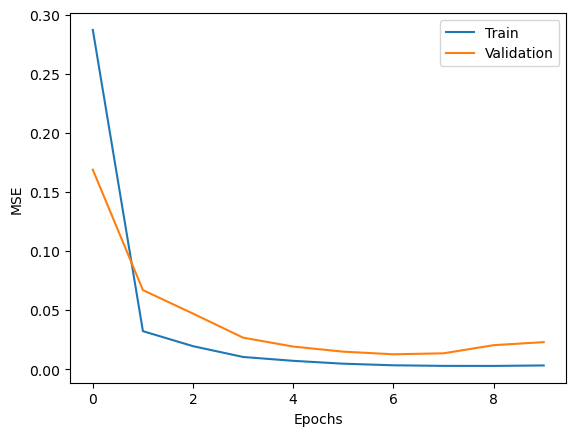

In [26]:
epochs_run_fake_unet = np.arange(len(train_losses_fake_unet))

plt.plot(epochs_run_fake_unet, train_losses_fake_unet, label='Train')
plt.plot(epochs_run_fake_unet, val_losses_fake_unet, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')

#### 3.1.2 Smoothing filter

In [27]:
# What if we try a smoothing filter?
Ypred_filtered = savgol_filter(Ymean_unscaled, 15, 3, axis=1)
Ypred_filtered.shape

(27, 256)

### 3.2 Comparison

In [28]:
fake_unet = torch.load("weights/best_model_fake_unet.pt")
fake_unet.to(device)
fake_unet.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        Ypred_fake_unet = fake_unet(x)

Ypred_fake_unet_unscaled = Ypred_fake_unet.squeeze().cpu() * std_train + mean_train

print(f"FCNN MSE: {((Ypred_fcnn_unscaled.squeeze().cpu() - Y_test)**2).mean().item():.6f}")
print(f"Unet MSE: {((Ypred_unet_unscaled.squeeze().cpu() - Y_test)**2).mean().item():.6f}")
print(f"Fake Unet MSE: {((Ypred_fake_unet_unscaled.squeeze().cpu() - Y_test)**2).mean().item():.6f}")
print(f"Mean signal MSE: {((Ymean_unscaled - Y_test)**2).mean():.6f}")
print(f"Filtered mean signal MSE: {((Ypred_filtered - Y_test)**2).mean():.6f}")

FCNN MSE: 0.001351
Unet MSE: 0.000746
Fake Unet MSE: 0.001555
Mean signal MSE: 0.009136
Filtered mean signal MSE: 0.003559


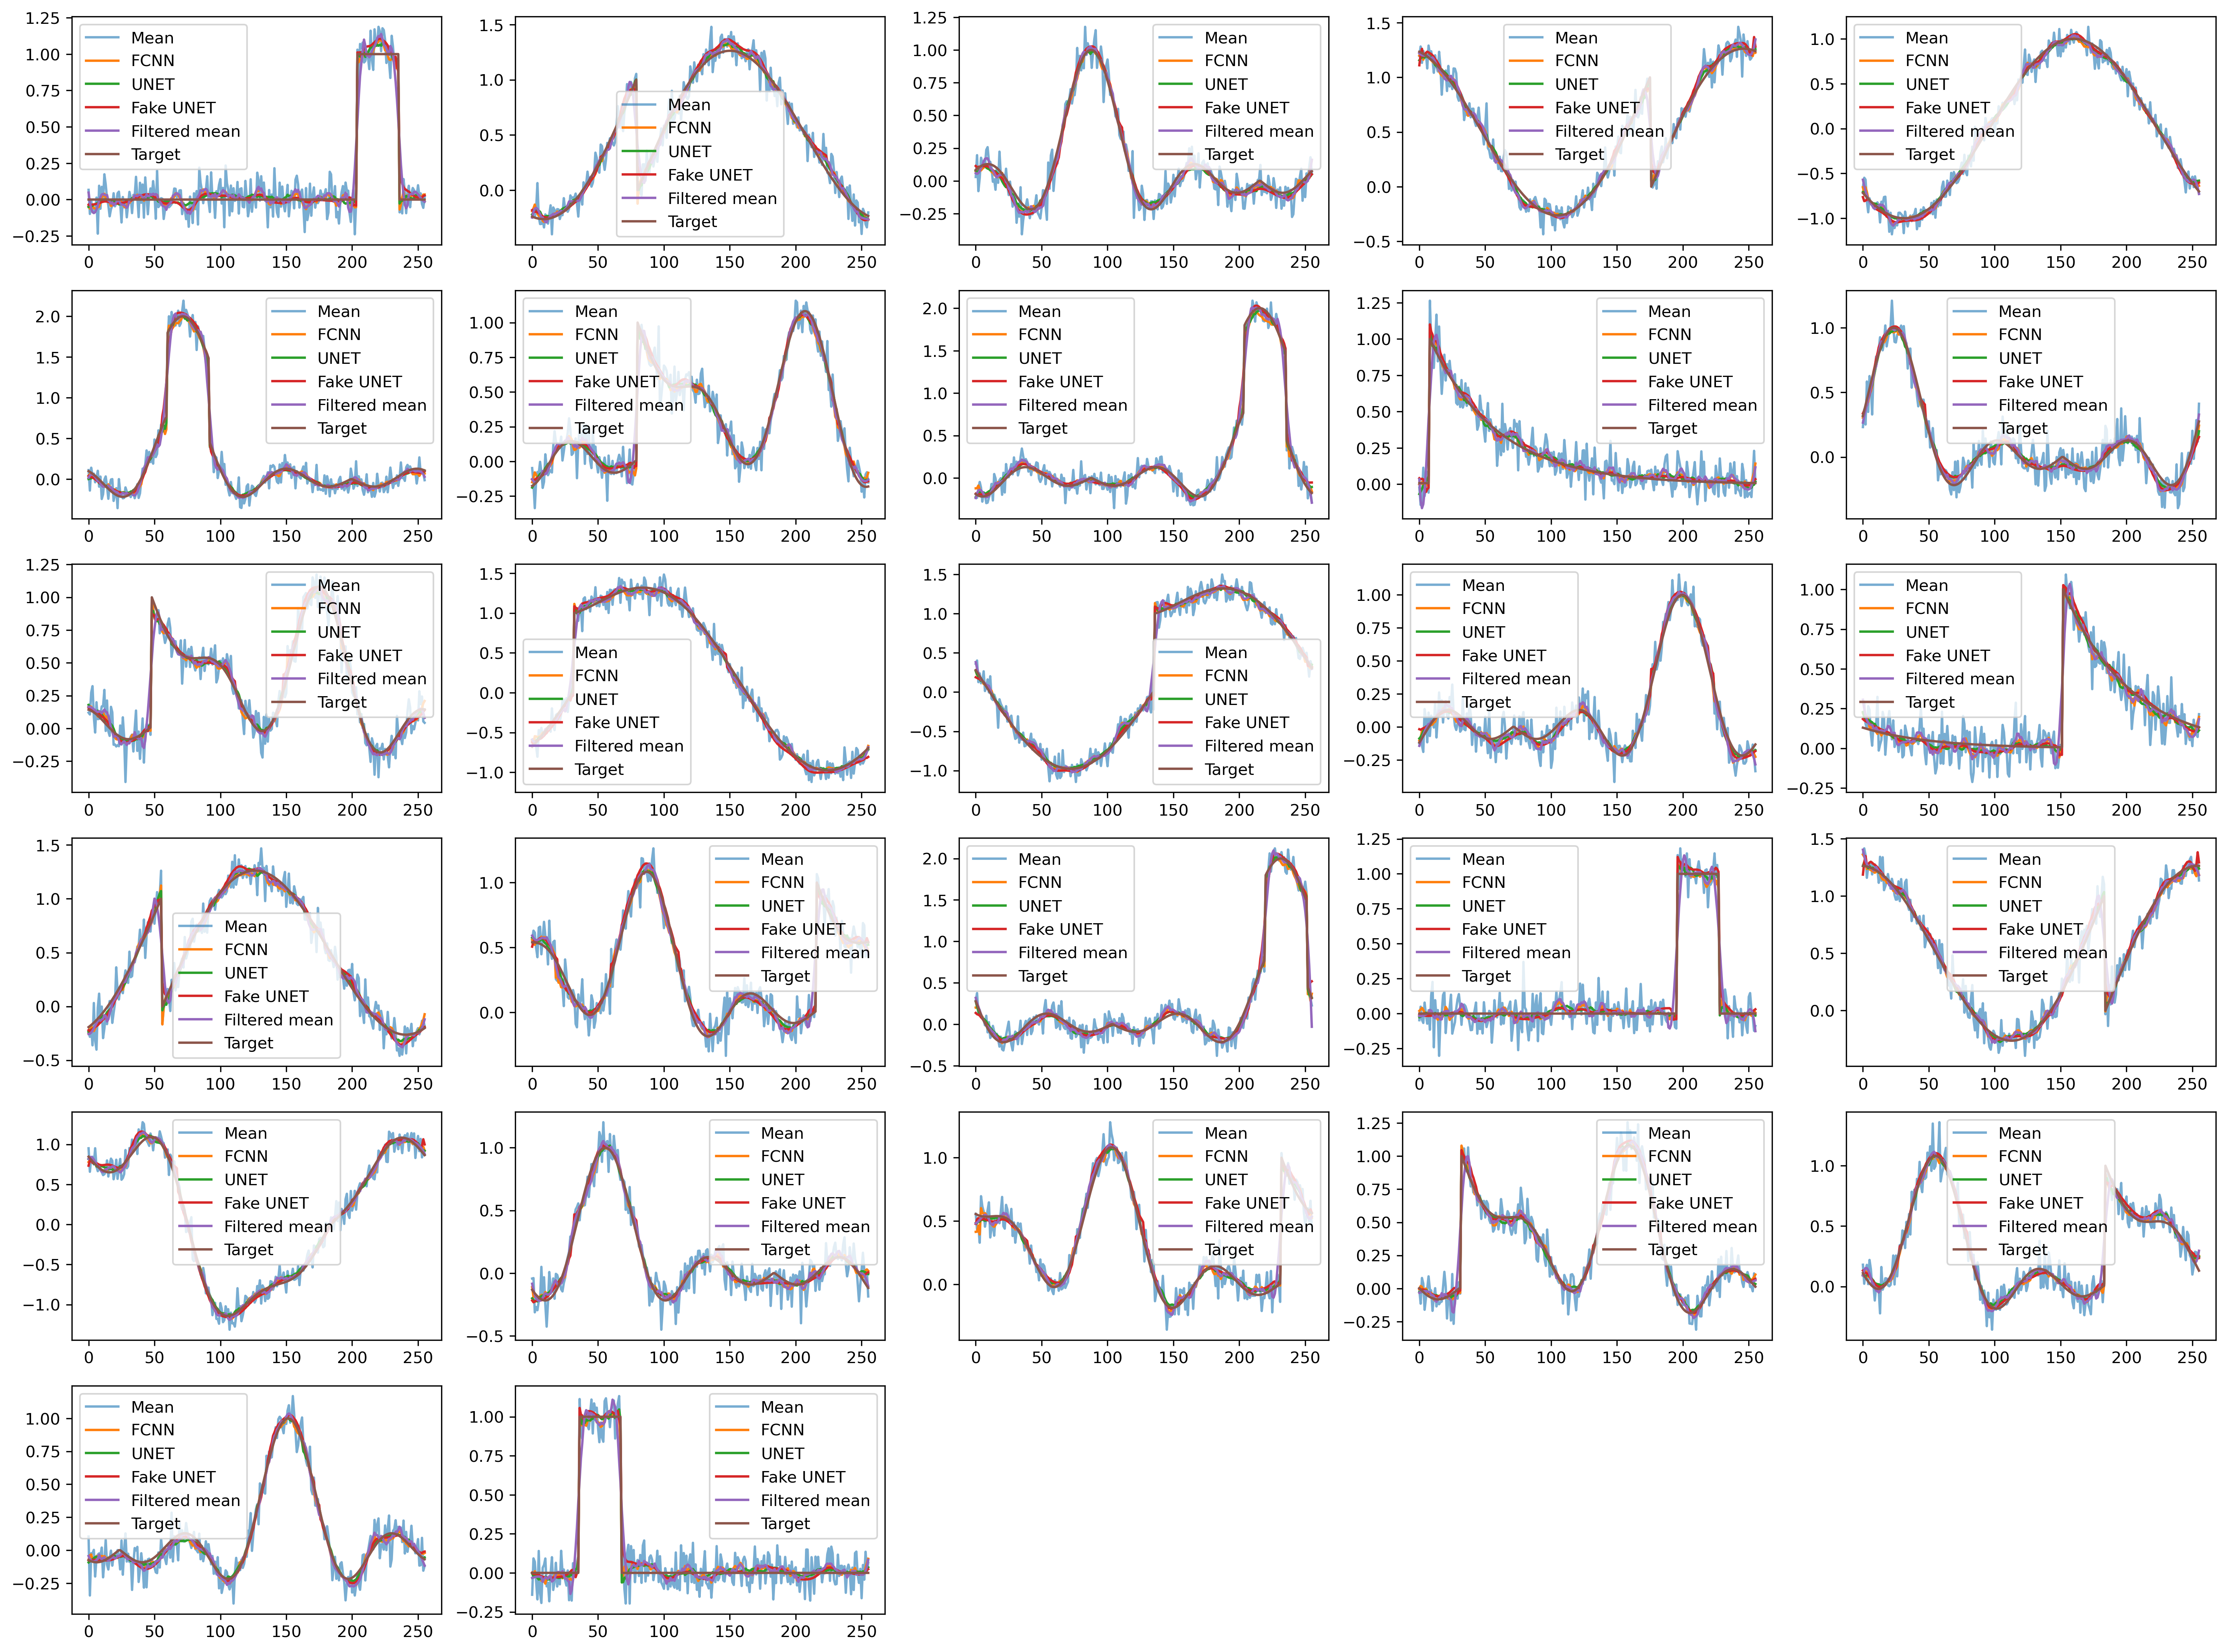

In [29]:
#Showing results
plt.figure(figsize = (24,18), dpi = 300)
for (ii) in range(27):
    plt.subplot(6, 5, ii+1)
    #plt.plot(X_test2[ii,:,0], label = "Noisy")
    plt.plot(Ymean_unscaled[ii], label="Mean", alpha=0.6)
    plt.plot(Ypred_fcnn_unscaled[ii], label="FCNN")
    plt.plot(Ypred_unet_unscaled[ii], label="UNET")
    plt.plot(Ypred_fake_unet_unscaled[ii], label="Fake UNET")
    plt.plot(Ypred_filtered[ii], label="Filtered mean")
    plt.plot(Y_test[ii], label="Target")
    plt.legend()
plt.show()